In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import ast

parent_dir = "/home/tvanhout/oxides_ML/models/batch_size/augment"
independent_variable = 'train_batch_size'

In [148]:
summary_data = []

for model_folder in os.listdir(parent_dir):
    model_path = os.path.join(parent_dir, model_folder)
    
    if os.path.isdir(model_path):
        summary_entry = {'Model': model_folder}

        # Load test set
        test_set_path = os.path.join(model_path, "test_set.csv")
        if os.path.exists(test_set_path):
            df_test = pd.read_csv(test_set_path)
            summary_entry['MAE'] = df_test['Abs_error_eV'].mean()

        # Load hyperparameters from .txt file
        hyperparam_path = os.path.join(model_path, "input.txt")
        if os.path.exists(hyperparam_path):
            with open(hyperparam_path, "r") as file:
                hyperparams = ast.literal_eval(file.read())

            def flatten_dict(d, parent_key='', sep='_'):
                items = []
                for k, v in d.items():
                    new_key = f"{parent_key}{sep}{k}" if parent_key else k
                    if isinstance(v, dict):
                        items.extend(flatten_dict(v, new_key, sep=sep).items())
                    else:
                        items.append((new_key, v))
                return dict(items)

            flat_hyperparams = flatten_dict(hyperparams)

            summary_entry.update(flat_hyperparams)

        summary_data.append(summary_entry)

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.iloc[:, :-3]


# df_summary.info()


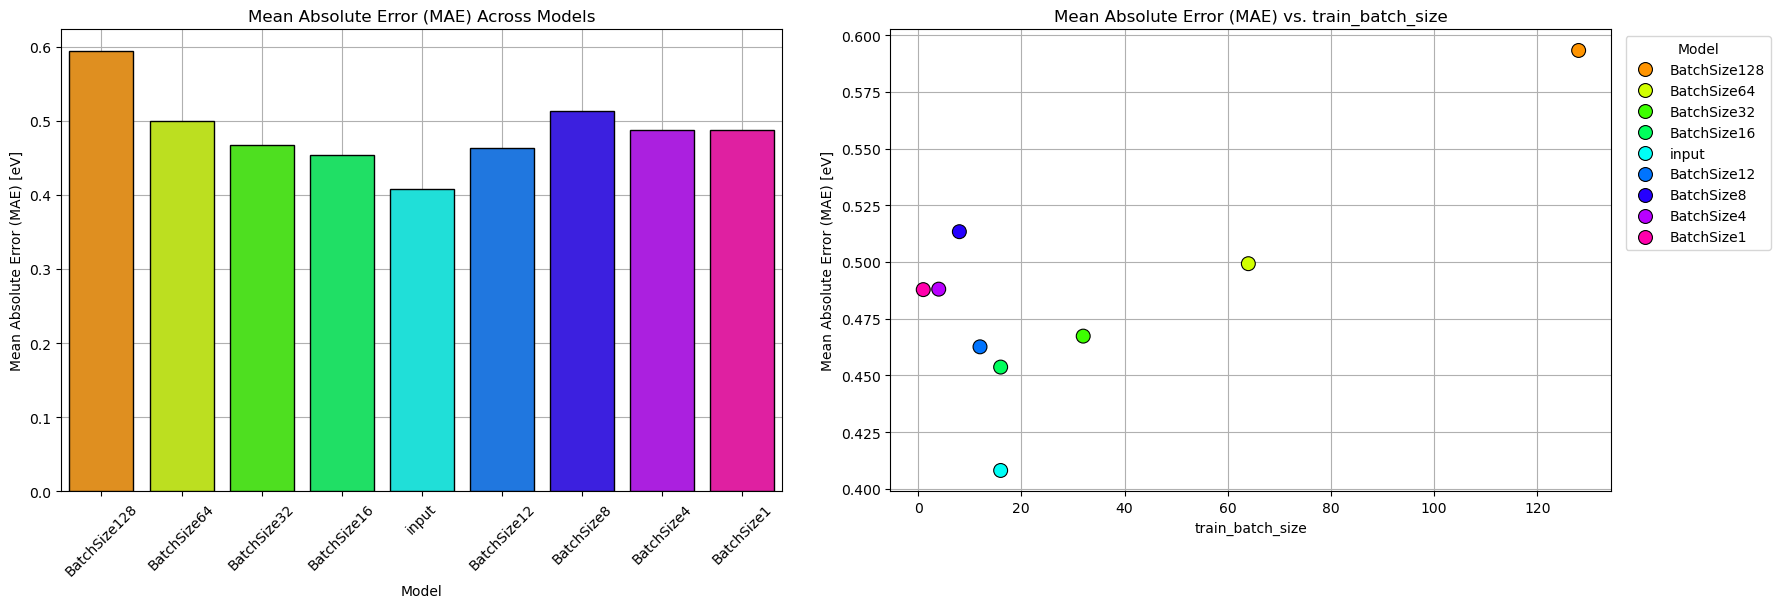

In [149]:
df_sorted = df_summary.sort_values([independent_variable], ascending=False).reset_index()

plt.figure(figsize=(20, 6))

# First subplot
plt.subplot(1, 2, 1)
sns.barplot(data=df_sorted, x='Model', y='MAE', hue='Model', palette='hsv', legend=False, edgecolor='black', zorder=10)
plt.title('Mean Absolute Error (MAE) Across Models')
plt.ylabel('Mean Absolute Error (MAE) [eV]')
plt.xticks(rotation=45)
plt.grid(True)

# Second subplot
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_sorted, x=independent_variable, y='MAE', hue='Model', palette='hsv', s=100, edgecolor='black', zorder=10)
plt.xlabel(independent_variable)
plt.ylabel('Mean Absolute Error (MAE) [eV]')
plt.title(f'Mean Absolute Error (MAE) vs. {independent_variable}')
plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)

plt.subplots_adjust(wspace=0.15)
plt.show()



In [150]:
df_sorted['MAE']

0    0.593300
1    0.499283
2    0.467340
3    0.453688
4    0.408099
5    0.462618
6    0.513393
7    0.488050
8    0.487845
Name: MAE, dtype: float64

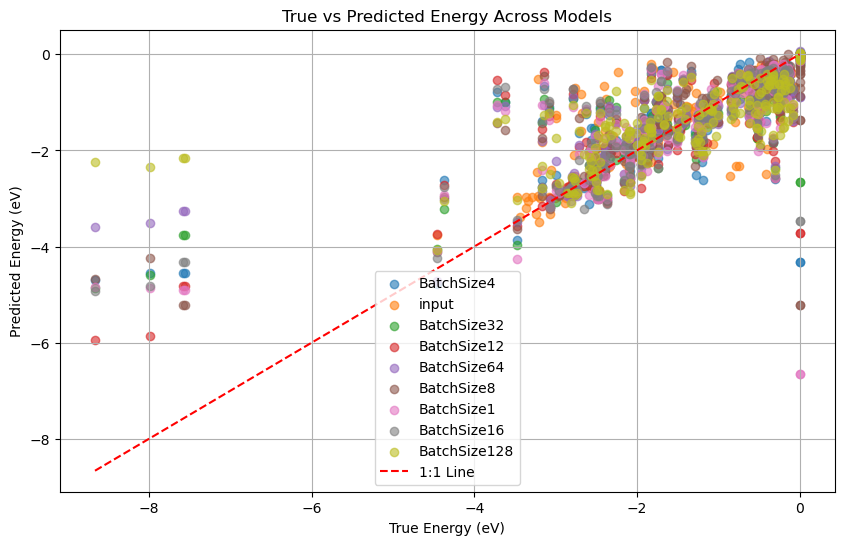

In [151]:
plt.figure(figsize=(10,6))

for model_folder in os.listdir(parent_dir):
    model_path = os.path.join(parent_dir, model_folder)
    
    if os.path.isdir(model_path):
        test_set_path = os.path.join(model_path, "test_set.csv")
        if os.path.exists(test_set_path):
            df_test = pd.read_csv(test_set_path)
            plt.scatter(df_test['True_eV'], df_test['Prediction_eV'], label=model_folder, alpha=0.6)

plt.plot([df_test['True_eV'].min(), df_test['True_eV'].max()], 
         [df_test['True_eV'].min(), df_test['True_eV'].max()], 'r--', label='1:1 Line')

plt.xlabel('True Energy (eV)')
plt.ylabel('Predicted Energy (eV)')
plt.title('True vs Predicted Energy Across Models')
plt.legend()
plt.grid(True)
plt.show()
